In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import air_traff_utils as atu
from sklearn import preprocessing

import ipdb

In [2]:
atu.setup_seed(12)

In [3]:
def plot_tensor_quick(tensor):
#     plt.figure()
    try:
        plt.plot(tensor.cpu().detach().numpy())
    except Exception as e:
        plt.plot(tensor.detach().numpy())

# Loading Data

In [4]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [28]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [58]:
data_X_df = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'geometry', 'if_plot'], axis=1))
data_X_df.index = range(data_X_df.shape[0])
data_X_df.head(2)

,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,D1C,...,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name
0,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,2.193174,...,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,5.484528,...,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT"


In [59]:
data_X_df['CSA_Code'] = ''
for i in data_X_df.index:
    CSA_Name = data_X_df.loc[i, 'CSA_Name']
    data_X_df.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

data_X_df = data_X_df[['TotPop', 'D3A', 'D4A', 'D4C', 'INTPTLAT', 'INTPTLON', 'CSA_Name', 'CSA_Code']]
print(data_X_df.shape)
data_X_df.head(2)

(24, 8)


,TotPop,D3A,D4A,D4C,INTPTLAT,INTPTLON,CSA_Name,CSA_Code
0,6584708,11.808044,-67955.508346,-60276.863137,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,18.586822,-39255.813819,-28799.664050,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


In [60]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

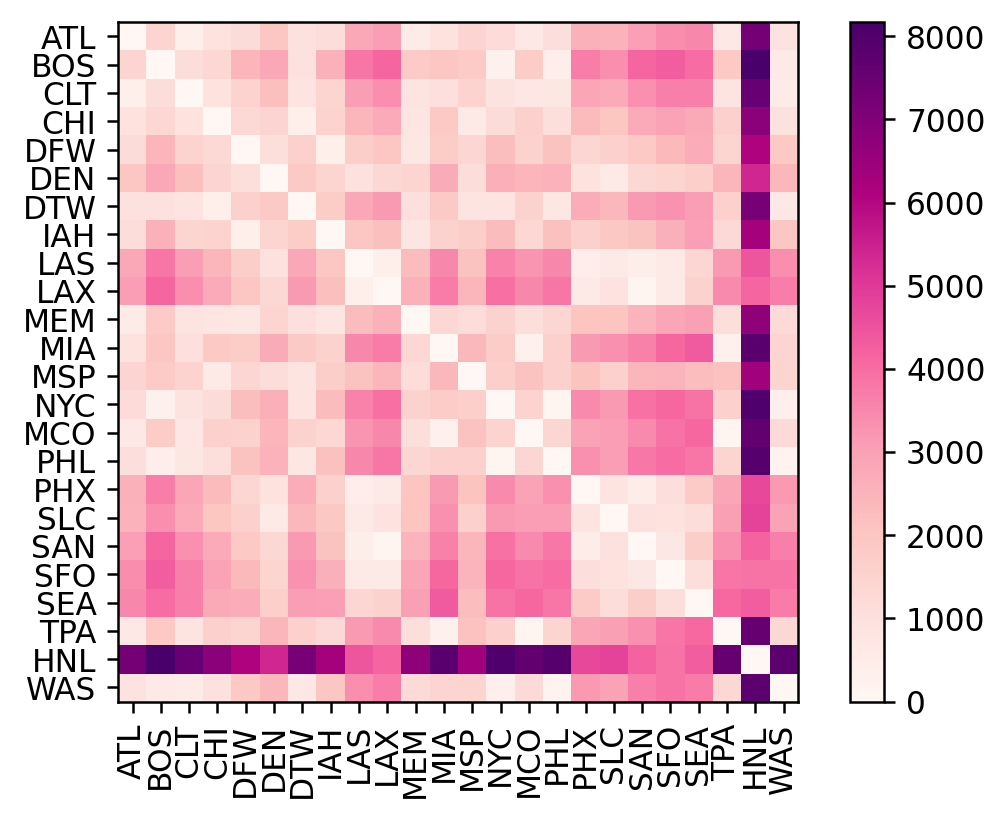

In [223]:
dist_mat = np.zeros([24, 24])
for i in range(24):
    lat1 = data_X_df.loc[i, 'INTPTLAT']
    lon1 = data_X_df.loc[i, 'INTPTLON']
    for j in range(24):
        lat2 = data_X_df.loc[j, 'INTPTLAT']
        lon2 = data_X_df.loc[j, 'INTPTLON']
        
        dist_mat[i, j] = distance(lat1, lat2, lon1, lon2)

plt.figure(dpi=225)
plt.imshow(dist_mat, cmap='RdPu')
plt.yticks(range(24), data_X_df['CSA_Code'])
plt.xticks(range(24), data_X_df['CSA_Code'], rotation=90)
plt.colorbar()

dist_vec = dist_mat.reshape(-1, 1)
scalar_dist = preprocessing.MinMaxScaler().fit(dist_vec)
dist_vec = scalar_dist.transform(dist_vec)
dist_mat = dist_vec.reshape(24, 24)


(24, 24)


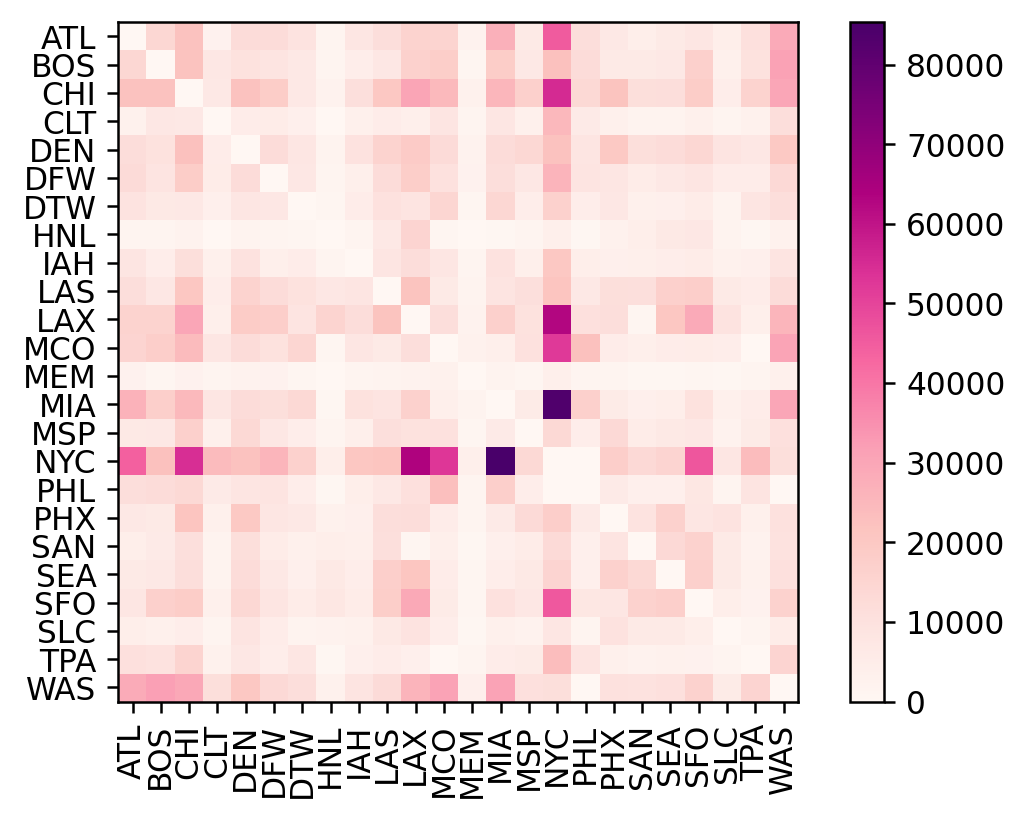

In [220]:
# Illustration of OD matrix
print(OD_df.shape)
plt.figure(dpi=225)

plt.imshow(OD_df, cmap='RdPu')
plt.yticks(range(24), OD_df.index)
plt.xticks(range(24), OD_df.index, rotation=90)
plt.colorbar()


# Prepare Feature Pairs
## For each OD pair in the OD matrix, it has its feature combination, [feature of loc1, feature of loc2, distance]

In [63]:
def get_logOD(OD):
    # OD is originally DataFrame
    OD = np.array(OD)
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            if OD[i, j]!=0:
                OD[i, j] = np.log(OD[i, j])
    return OD

In [199]:
data_X = np.array(data_X_df.iloc[:, :4])
scalar_data_X_feature = preprocessing.StandardScaler().fit(data_X)
data_X = scalar_data_X_feature.transform(data_X)# shape: [num_cities * num_features*2+1, 1]
# data_X = data_X.reshape(1, -1)
print('data_X | Shape:', data_X.shape, ', type: %s'%type(data_X))

OD = np.array(OD_df)  # shape: [num_cities, num_cities]
OD = OD.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD)
OD = scalar_OD.transform(OD).T
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

print('dist_mat | Shape:', dist_mat.shape, ', type: %s'%type(dist_mat))

data_X | Shape: (24, 4) , type: <class 'numpy.ndarray'>
OD | Shape: (1, 576) , type: <class 'numpy.ndarray'>
dist_mat | Shape: (24, 24) , type: <class 'numpy.ndarray'>


# Define VAE Model Structure

In [200]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [138]:
# Model specification
class VAE_FC_Net(nn.Module):
    def __init__(self, in_out_size, feature_dim, dropout_p=0.0):
        super(VAE_FC_Net, self).__init__()
        self.in_out_size = in_out_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder1 = nn.Sequential(
            nn.Linear(in_out_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.encoder21 = nn.Sequential(
            nn.Linear(32, feature_dim),
            nn.Dropout(dropout_p)
        )
        self.encoder22 = nn.Sequential(
            nn.Linear(128, feature_dim),
            nn.Dropout(dropout_p)
        )
        
        self.decoder1 = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, in_out_size),
            nn.LeakyReLU()
        )
        
        
    def forward(self, x):
        # shape of x: [batch, ]
#         ipdb.set_trace()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = self.encoder1(x)
        x = x.view(1, -1)
        # shape of "x" here = [batch, feature_dim]
        hidden_mean = self.encoder21(x)
        log_hidden_var = self.encoder22(x)
        std = log_hidden_var.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        
        # sampling process
        sampled_feature = hidden_mean + eps.mul(std)
#         print(hidden_mean, sampled_feature)
        
        y = self.decoder2(self.decoder1(sampled_feature))  # vae
#         y = self.decoder2(self.decoder1(hidden_mean))  # ae
        return hidden_mean, log_hidden_var, y
    

# Preparing data for PyTorch

In [201]:
prop = 0.5

dist_train = dist_mat[int(24*prop):, int(24*prop):].reshape(1, -1)
dist_val = dist_mat[:int(24*prop), :int(24*prop)].reshape(1, -1)

OD_train = OD.reshape(24, 24)[int(24*prop):, int(24*prop):].reshape(1, -1)
OD_val = OD.reshape(24, 24)[:int(24*prop), :int(24*prop)].reshape(1, -1)

input_train = np.concatenate([OD_train, dist_train], axis=0)
input_val = np.concatenate([OD_val, dist_val], axis=0)

data_X_train = data_X[int(24*prop):, :]
data_X_val = data_X[:int(24*prop), :l]


In [202]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_train = torch.tensor(input_train, dtype=torch.float32, device=device, requires_grad=True)
input_val = torch.tensor(input_val, dtype=torch.float32, device=device, requires_grad=True)
OD_train = torch.tensor(OD_train, dtype=torch.float32, device=device, requires_grad=True)
OD_val = torch.tensor(OD_val, dtype=torch.float32, device=device, requires_grad=True)
data_X_train = torch.tensor(data_X_train, dtype=torch.float32, device=device, requires_grad=True)
data_X_val = torch.tensor(data_X_val, dtype=torch.float32, device=device, requires_grad=True)

print('input_train', type(input_train), input_train.shape)
print('input_val', type(input_val), input_val.shape)
print('OD_train', type(OD_train), OD_train.shape)
print('OD_val', type(OD_val), OD_val.shape)
print('data_X_train', type(data_X_train), data_X_train.shape)
print('data_X_val', type(data_X_val), data_X_val.shape)


input_train <class 'torch.Tensor'> torch.Size([2, 144])
input_val <class 'torch.Tensor'> torch.Size([2, 144])
OD_train <class 'torch.Tensor'> torch.Size([1, 144])
OD_val <class 'torch.Tensor'> torch.Size([1, 144])
data_X_train <class 'torch.Tensor'> torch.Size([12, 4])
data_X_val <class 'torch.Tensor'> torch.Size([12, 4])


## Define KL Divergence between two Gaussian Distributions
<img src="./imgs/KL.png" width="500">
<img src="./imgs/KL_use .png" width="350">
Note that $\sigma_2=1$

In [203]:
def KL_loss(mean1, logvar1, mean2):
    # mean1, std1, mean2, std2 are 2-D matrices (type: tensor)
    # the first dimension is batch size, 
    # the second is number of variables
    
    # mean1, std1 are mean, std of predicted value
    # mean2, std2 are mean, std of true value, std2=1
    # 1 and 2 are irreversible
    
    assert mean1.shape[0] == mean2.shape[0]
    assert mean1.shape[1] == mean2.shape[1]
#     ipdb.set_trace()
    KL_div = -0.5*(logvar1 - logvar1.exp() - (mean1)**2 + 1).sum(axis=1).mean()
    
    return KL_div  # depends on the reconstruction loss reduction (either sum or mean)

# Initialize the Model

In [204]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
X = OD_train
model = VAE_FC_Net(in_out_size=X.shape[1], feature_dim=data_X_train.shape[1]).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_recons = []
loss_set_KL = []
loss_set_train = []
loss_set_gen = []

print('Input size %i'%X.shape[1])
print('There are %i features'%data_X_train.shape[1])

Input size 144
There are 4 features


In [190]:
# summary(model) 

# Train the Model

In [191]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [192]:
gen_mean, log_hidden_var, out = model(X)
# out

In [193]:
model.train()
true_mean = data_X_train

epochs = 1000
   
for e in range(epochs+1):
    #ipdb.set_trace()

    gen_mean, log_hidden_var, out = model(X)
    loss_re = loss_recon(out, OD_train)
    loss_KL = KL_loss(gen_mean, log_hidden_var, true_mean)
#     loss_KL = ((gen_mean - true_mean)**2).sum(axis=1).mean()  # mmd loss
    loss = loss_re + loss_KL

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    out_gen = model.decoder2(model.decoder1(data_X_val))
#         ipdb.set_trace()
    loss_gen = loss_recon(out_gen, OD_val)

    loss_set_gen.append(loss_gen.cpu().detach().numpy())
    loss_set_train.append(loss.cpu().detach().numpy())
    loss_set_recons.append(loss_re.cpu().detach().numpy())
    loss_set_KL.append(loss_KL.cpu().detach().numpy())

    if e%10==0:



        # print the information of epoch e, the last mini-batch
        print('Epoch %i   success, gen loss:%.6f, reconstruction loss:%.6f, KL loss:%.10f, '%(
            e, loss_gen.cpu().detach().numpy(), loss_re.cpu().detach().numpy(), loss_KL.cpu().detach().numpy()
        ))
        

Epoch 0   success, gen loss:0.014634, reconstruction loss:0.028322, KL loss:20.1714801788, 
Epoch 10   success, gen loss:0.014077, reconstruction loss:0.023412, KL loss:15.9116373062, 
Epoch 20   success, gen loss:0.017764, reconstruction loss:0.013221, KL loss:4.1452918053, 
Epoch 30   success, gen loss:0.017751, reconstruction loss:0.004575, KL loss:0.6854140162, 
Epoch 40   success, gen loss:0.023198, reconstruction loss:0.001248, KL loss:0.3110621572, 
Epoch 50   success, gen loss:0.021705, reconstruction loss:0.001401, KL loss:0.0789122581, 
Epoch 60   success, gen loss:0.024285, reconstruction loss:0.001227, KL loss:0.0392388105, 
Epoch 70   success, gen loss:0.021012, reconstruction loss:0.002092, KL loss:0.0161520243, 
Epoch 80   success, gen loss:0.022392, reconstruction loss:0.004985, KL loss:0.0058189034, 
Epoch 90   success, gen loss:0.020968, reconstruction loss:0.000718, KL loss:0.0022219419, 
Epoch 100   success, gen loss:0.027086, reconstruction loss:0.003330, KL loss:0

Epoch 950   success, gen loss:0.026752, reconstruction loss:0.000115, KL loss:0.0000020266, 
Epoch 960   success, gen loss:0.025629, reconstruction loss:0.000455, KL loss:0.0000011325, 
Epoch 970   success, gen loss:0.025740, reconstruction loss:0.000062, KL loss:0.0000036061, 
Epoch 980   success, gen loss:0.025551, reconstruction loss:0.000093, KL loss:0.0000043809, 
Epoch 990   success, gen loss:0.024509, reconstruction loss:0.000159, KL loss:0.0000031888, 
Epoch 1000   success, gen loss:0.025719, reconstruction loss:0.000036, KL loss:0.0000015199, 


In [194]:
def plot_loss(gen, train, recons, KL, title):
    fig = plt.figure(figsize=[16,5])
    ax1 = fig.add_subplot(141)
    ax1.plot(gen)
    ax1.set_xlabel('Epoches/100')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(gen)])
    ax1.set_title('Generation loss')
    ax1.grid()
    ax2 = fig.add_subplot(142)
    ax2.plot(train)
    ax2.set_xlabel('Epoches/100')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    ax3 = fig.add_subplot(143)
    ax3.plot(recons)
    ax3.set_xlabel('Epoches/100')
    ax3.set_ylabel('MSELoss')
    ax3.set_ylim([0, max(recons)])
    ax3.set_title('Reconstruction loss')
    ax3.grid()
    ax4 = fig.add_subplot(144)
    ax4.plot(KL)
    ax4.set_xlabel('Epoches/100')
    ax4.set_ylabel('MSELoss')
    ax4.set_ylim([0, max(KL)])
    ax4.set_title('KL loss')
    ax4.grid()
    
    plt.suptitle(title)

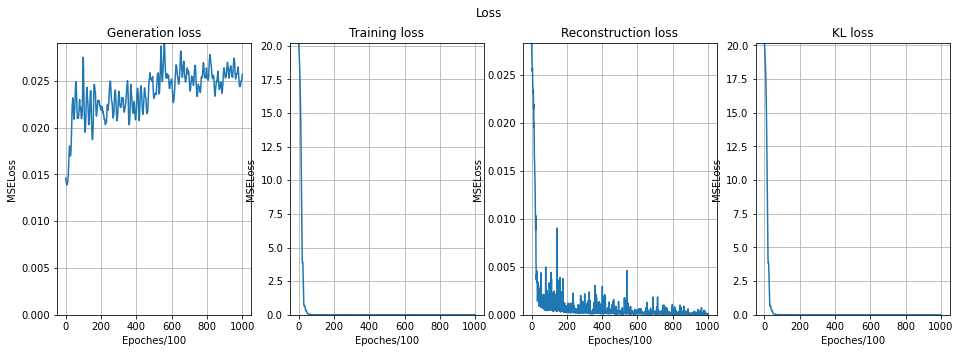

In [195]:
plot_loss(loss_set_gen, loss_set_train, loss_set_recons, loss_set_KL, 'Loss')

In [179]:
true_mean

tensor([[-0.5125, -0.4820, -0.3982, -0.1946,  3.2292,  1.1381,  0.9005,  0.7876,
         -0.5169, -1.2117, -1.1557, -1.1265,  0.1359,  0.5674,  0.5697,  0.8992,
         -0.3524,  0.3943, -0.0053,  0.1453, -0.7941, -0.5763,  0.5495,  0.7433,
         -0.6363,  0.8070,  0.9285, -2.1848,  0.6090,  1.0244,  0.9262,  0.5495,
         -0.3594, -0.4850,  0.4947,  0.8871, -0.6907,  0.0810,  0.1042,  0.5564,
         -1.0979, -0.0162,  1.4060,  1.8035,  0.6319, -0.2672,  0.1165,  0.3141]],
       requires_grad=True)

In [196]:
model.encoder21(model.encoder1(OD_train))

tensor([[-0.5125, -0.4820, -0.3982, -0.1946,  3.2293,  1.1381,  0.9005,  0.7876,
         -0.5169, -1.2117, -1.1557, -1.1265,  0.1359,  0.5674,  0.5697,  0.8992,
         -0.3524,  0.3943, -0.0058,  0.1454, -0.7941, -0.5762,  0.5495,  0.7433,
         -0.6363,  0.8070,  0.9285, -2.1849,  0.6090,  1.0244,  0.9262,  0.5495,
         -0.3593, -0.4850,  0.4946,  0.8872, -0.6907,  0.0801,  0.1042,  0.5564,
         -1.0979, -0.0162,  1.4061,  1.8035,  0.6319, -0.2671,  0.1164,  0.3141]],
       grad_fn=<AddmmBackward>)

In [197]:
out_gen = model.decoder2(model.decoder1(data_X_val))
gen = out_gen.cpu().detach().numpy().copy()
labels = OD_val.cpu().detach().numpy().copy()
gen[labels==0] = 0

m = 0.

print('The mae loss is %.4f'%atu.mae_loss_func(gen, labels, m))
print('The mape loss is %.4f'%atu.mape_loss_func(gen, labels, m))
print('The smape loss is %.4f'%atu.smape_loss_func(gen, labels, m))
print('The nrmse loss is %.4f'%atu.nrmse_loss_func(gen, labels, m))
print('The nmae loss is %.4f'%atu.nmae_loss_func(gen, labels, m))
print('CPC is %.5f'%atu.get_CPC(gen.T, labels.T))


The mae loss is 0.1149
The mape loss is 2.8709
The smape loss is 0.9218
The nrmse loss is 0.4848
The nmae loss is 0.3288
CPC is 0.45465


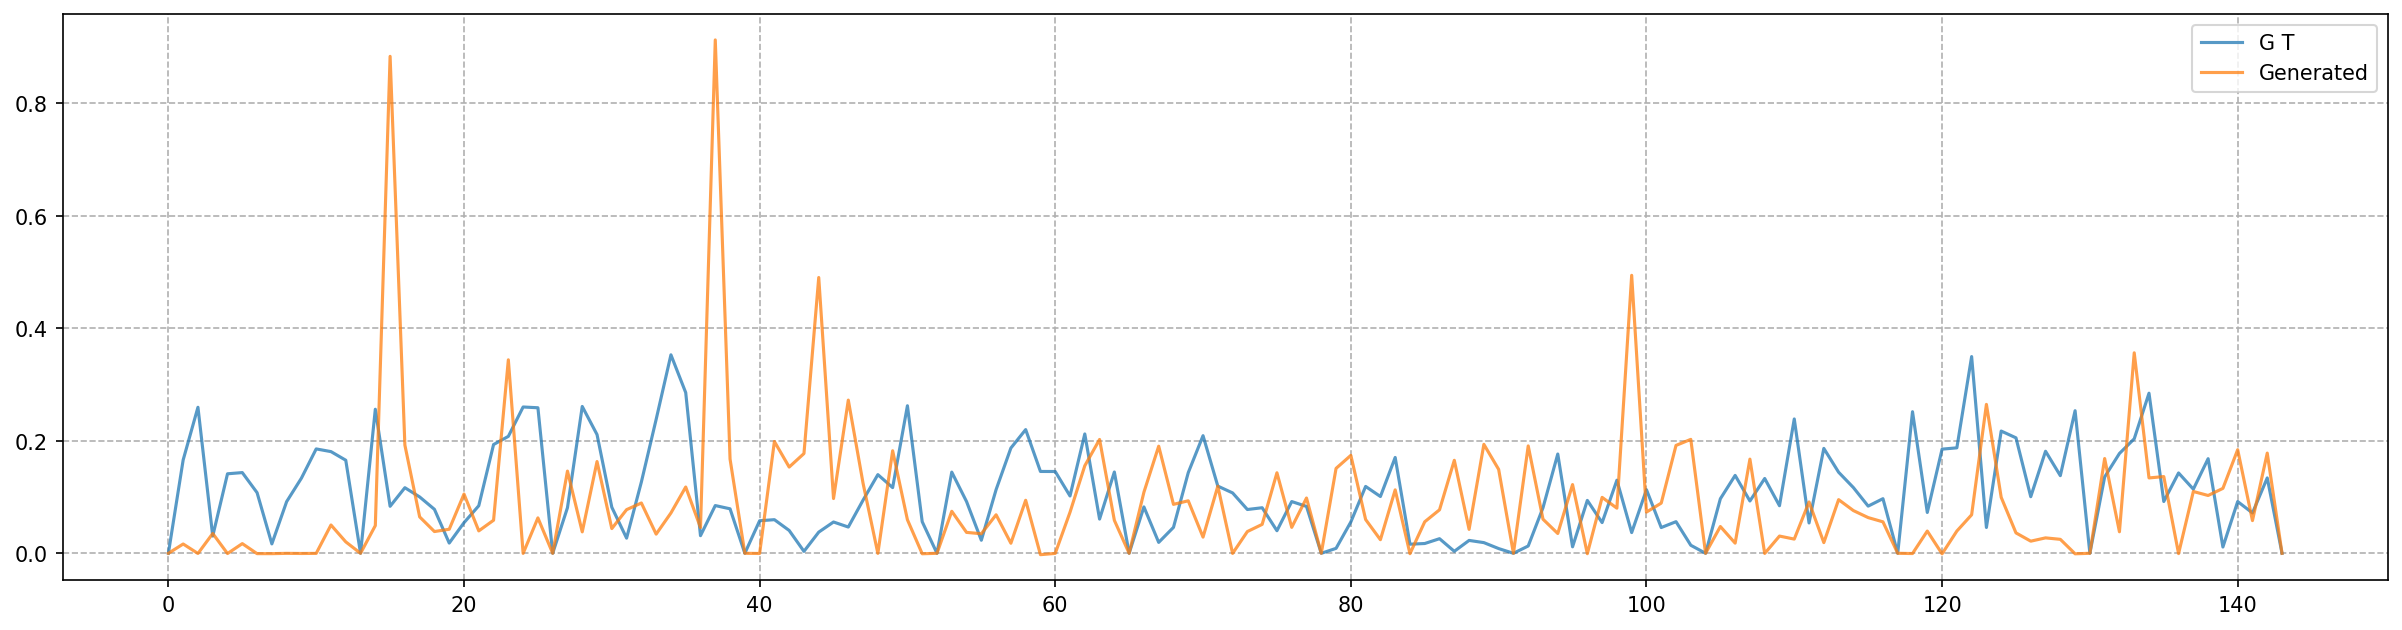

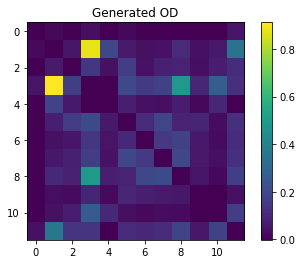

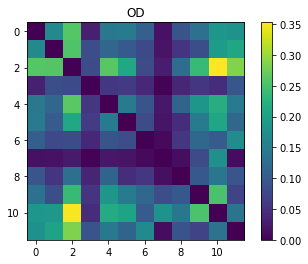

In [198]:
plt.figure(figsize=[20,5], dpi=150)
plt.plot(range(labels.shape[1]), labels.flatten(), label='G T', alpha=0.75)
plt.plot(range(gen.shape[1]), gen.flatten(), label='Generated', alpha=0.75)
plt.legend()
plt.grid(ls='--')

plt.figure()
plt.imshow(gen.reshape(12,12))
plt.title('Generated OD')
plt.colorbar()
plt.figure()
plt.imshow(labels.reshape(12,12))
plt.title('OD')
plt.colorbar()


In [100]:
data_X_train

tensor([[ 0.0179,  0.3402, -0.7651,  0.6804,  0.2307, -0.6037, -0.2301,  0.0935,
         -0.8591,  2.4190, -1.0228,  0.0532]], requires_grad=True)

In [101]:
data_X_val

tensor([[-0.5125,  3.2292, -0.5169,  0.1359, -0.3524, -0.7941, -0.6363,  0.6090,
         -0.3594, -0.6907, -1.0979,  0.6319]], requires_grad=True)

# Visualization of OD

In [109]:
import geopandas as gpd

In [110]:
city_coor = CSA_df.iloc[:, :3]
city_coor.head(2)

,Airport,lat,lon
0,ATL,33.640833,-84.427222
1,BOS,42.363611,-71.006111


In [111]:
us_CSA_gpd = gpd.read_file('./data/us_CSA.shp')
us_state_gpd = gpd.read_file('./data/us_state.shp')
data_X_all = us_CSA_gpd.loc[us_CSA_gpd['if_plot']==1]
data_X_all.head(2)

,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ..."


In [132]:
def plot_OD(OD, labels, title):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(12, 24)
    labels = labels.reshape(12, 24)

    fig = plt.figure(figsize=[30, 20], dpi=75)
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.5, color='blue')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')

    low_lon_dest = []
    low_lat_dest = []
    mid_lon_dest = []
    mid_lat_dest = []
    high_lon_dest = []
    high_lat_dest = []
    low_lon_origin = []
    low_lat_origin = []
    mid_lon_origin = []
    mid_lat_origin = []
    high_lon_origin = []
    high_lat_origin = []


    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]
            trip_label = labels[i, j]

            org = OD_df.index[i+12]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']

            if trip_OD-labels.min()<(labels.max()-labels.min())*0.3:
                low_lon_dest.append(lon_dest)
                low_lat_dest.append(lat_dest)
                low_lon_origin.append(lon_origin)
                low_lat_origin.append(lat_origin)
            elif trip_OD-labels.min()>=(labels.max()-labels.min())*0.3 and trip_OD-labels.min()<(labels.max()-labels.min())*0.6:
                mid_lon_dest.append(lon_dest)
                mid_lat_dest.append(lat_dest)
                mid_lon_origin.append(lon_origin)
                mid_lat_origin.append(lat_origin)
            elif trip_OD-labels.min()>=(labels.max()-labels.min())*0.6:
                high_lon_dest.append(lon_dest)
                high_lat_dest.append(lat_dest)
                high_lon_origin.append(lon_origin)
                high_lat_origin.append(lat_origin)


    for i in range(len(low_lon_dest)):
        ax0.plot([low_lon_origin[i], low_lon_dest[i]], [low_lat_origin[i], low_lat_dest[i]], 'b', lw=0.3)

    for i in range(len(mid_lon_dest)):
        ax0.plot([mid_lon_origin[i], mid_lon_dest[i]], [mid_lat_origin[i], mid_lat_dest[i]], 'orange', lw=1)

    for i in range(len(high_lon_dest)):
        ax0.plot([high_lon_origin[i], high_lon_dest[i]], [high_lat_origin[i], high_lat_dest[i]], 'red', lw=1.5)

    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)



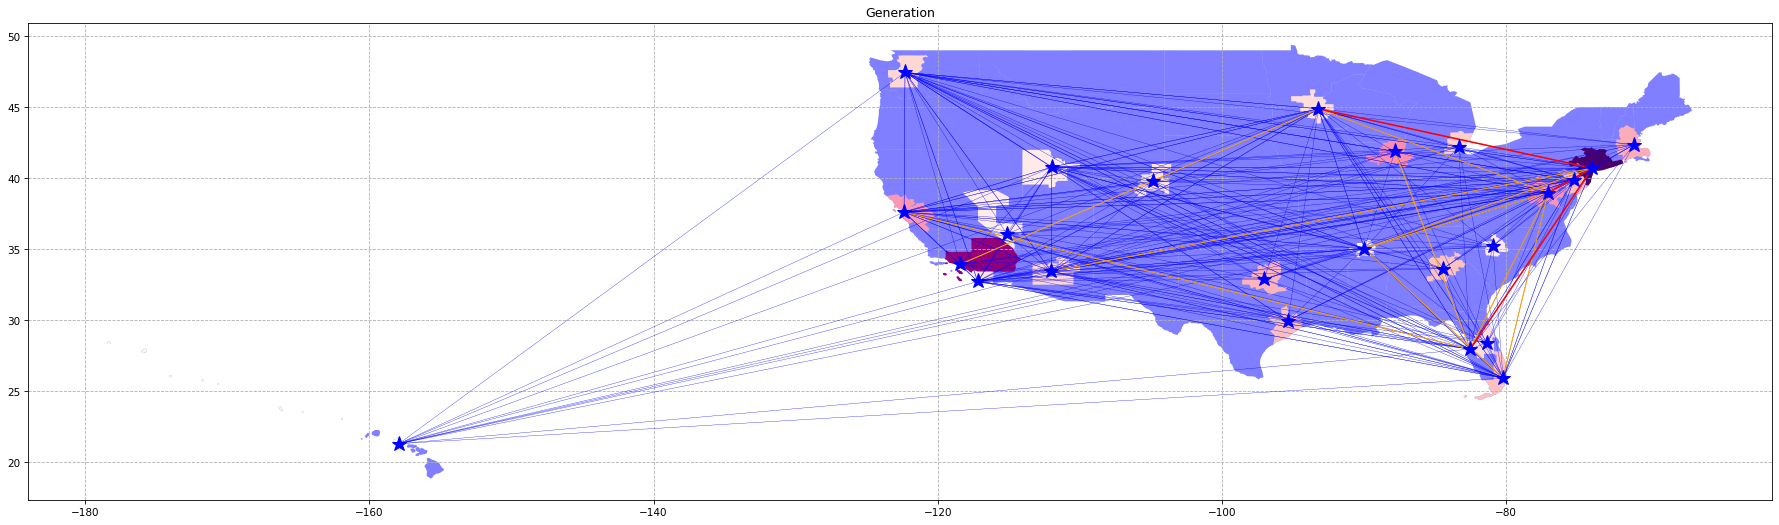

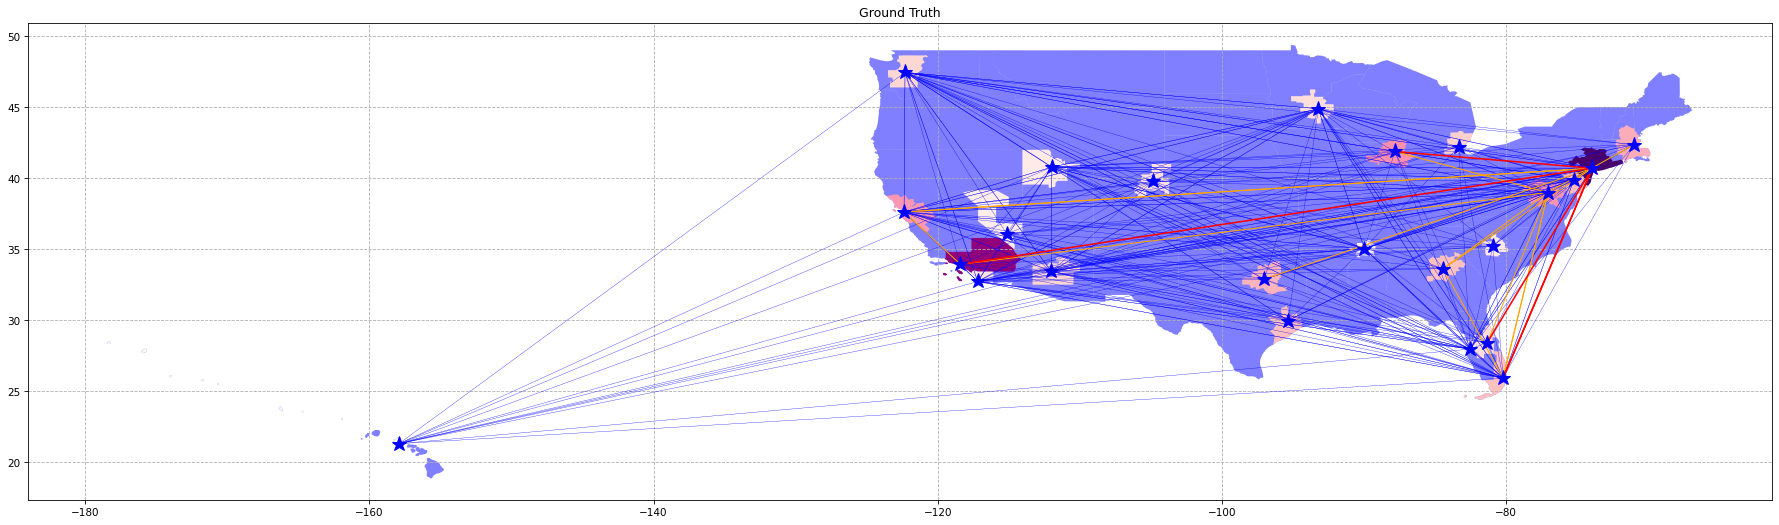

In [133]:
plot_OD(gen, labels, 'Generation')
plot_OD(labels, labels, 'Ground Truth')

In [134]:
def plot_OD2(OD, title):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(12, 24)

    fig = plt.figure(figsize=[30, 12])
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.5, color='blue')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
    
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]

            org = OD_df.index[i+12]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']
            
            c = min(np.sqrt(trip_OD), 1)
            ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], lw=np.sqrt(trip_OD), color=[c, c/5, c/5])
            
    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)
    return fig
    

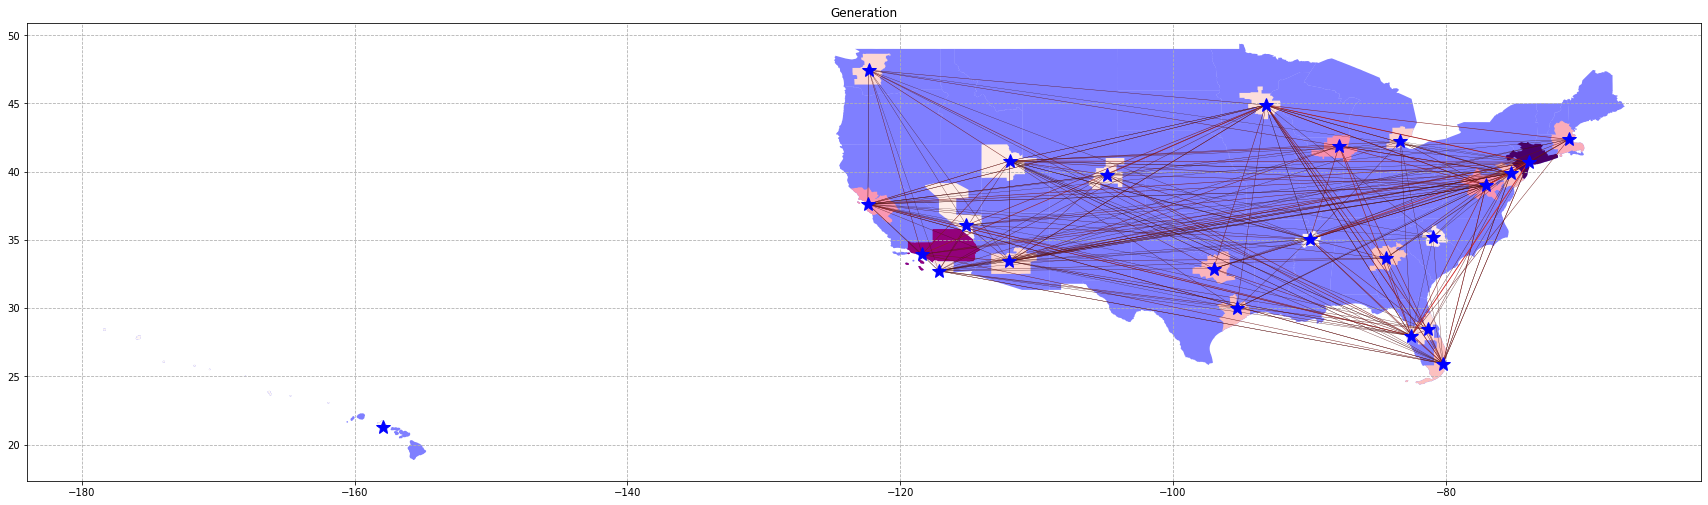

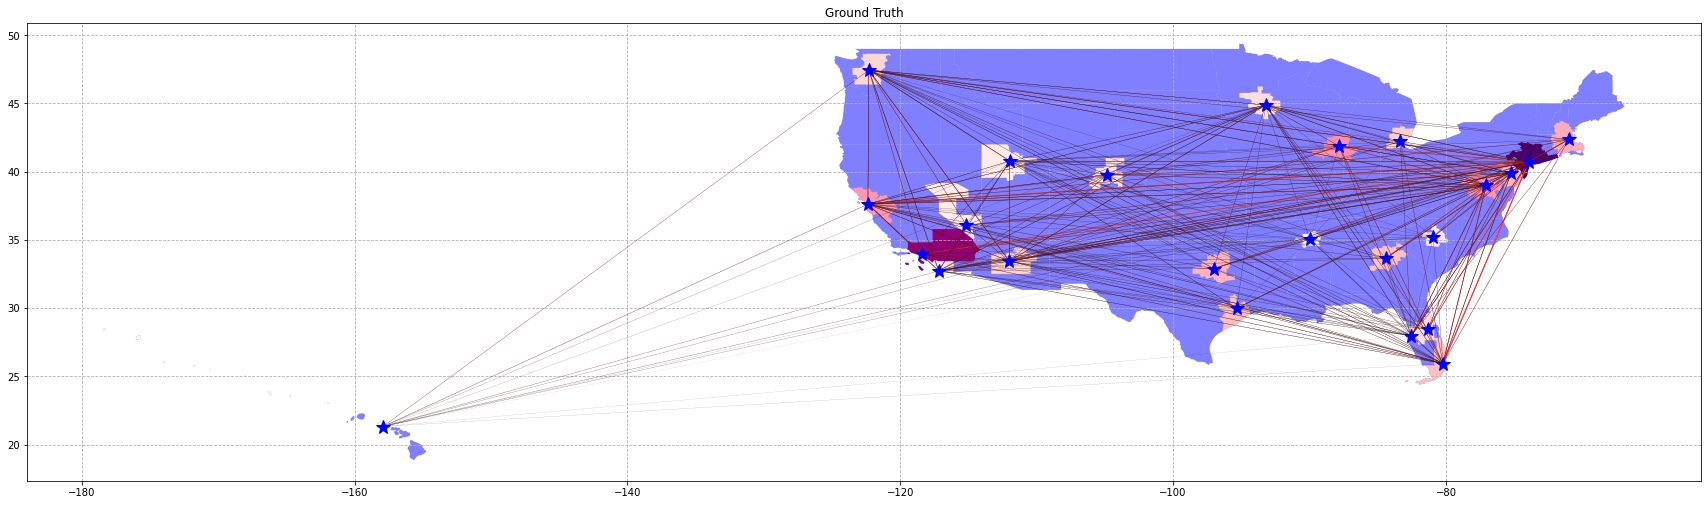

In [135]:
fig = plot_OD2(gen, 'Generation')
fig = plot_OD2(labels, 'Ground Truth')

# Testing Generation

,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
0,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
1,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."
2,2656704,172.0,16740.0,"Charlotte-Concord-Gastonia, NC-SC",51219,317050,627159,1265696,290237,416867,...,-62551.073532,-62538.175737,92675416,68856553,8.136293,35.253135,-80.858513,"Charlotte-Concord, NC-SC",1,"POLYGON ((-81.423002 34.586773, -81.4226939999..."
3,9907569,176.0,16980.0,"Chicago-Naperville-Elgin, IL-IN-WI",430705,1277966,1930840,4701005,1037535,1422923,...,-31270.250343,-31049.671972,1760490430,1526868394,11.707006,41.843309,-87.838419,"Chicago-Naperville, IL-IN-WI",1,"POLYGON ((-88.342083 41.112093, -88.3440399999..."
4,7651710,206.0,19100.0,"Dallas-Fort Worth-Arlington, TX",128183,863667,1692273,3681716,749692,1136376,...,-51568.055467,-51556.731122,1092448456,852396256,9.901212,32.866550,-96.929076,"Dallas-Fort Worth, TX-OK",1,POLYGON ((-97.37272899999999 32.20476199999999...
5,3466374,216.0,19740.0,"Denver-Aurora-Lakewood, CO",72278,401092,848653,1728319,343740,518469,...,-27803.356542,-27780.642170,205335302,173361210,11.683165,39.794497,-104.971125,"Denver-Aurora, CO",1,"POLYGON ((-105.972407 38.899257, -105.971622 3..."
6,5340674,220.0,19820.0,"Detroit-Warren-Dearborn, MI",182347,735618,1178379,2335294,523064,704125,...,-67569.227404,-67553.507700,480433023,409226164,8.900744,42.495622,-83.284399,"Detroit-Warren-Ann Arbor, MI",1,"POLYGON ((-83.781542 41.723020999999996, -83.7..."
7,6963733,288.0,26420.0,"Houston-The Woodlands-Sugar Land, TX",123722,781083,1468317,3045063,611743,913127,...,-54497.148044,-54480.953748,704894857,547953251,9.985997,29.756075,-95.413286,"Houston-The Woodlands, TX",1,POLYGON ((-96.38047999999999 28.38085899999999...
8,2185279,332.0,29820.0,"Las Vegas-Henderson-Paradise, NV",65082,298213,423327,966362,203935,385845,...,-19808.527153,-19763.085878,151956431,125441548,11.838269,36.157189,-115.165292,"Las Vegas-Henderson, NV",1,"POLYGON ((-115.391467 35.607319, -115.394098 3..."
9,18629045,348.0,37100.0,"Oxnard-Thousand Oaks-Ventura, CA",418037,1853427,3687226,8000345,1817798,2724371,...,-16354.076644,-16289.655517,2622747908,2332990778,12.890648,34.005801,-117.999677,"Los Angeles-Long Beach, CA",1,"MULTIPOLYGON (((-119.59252000000001 33.325823,..."


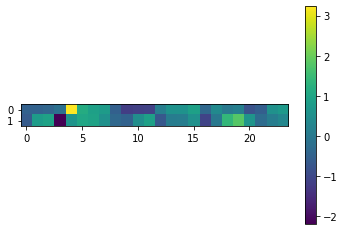

In [136]:
plt.imshow(data_X_val.reshape(-1, 24).detach().numpy())
plt.colorbar()
us_CSA_use.index = range(24)
us_CSA_use

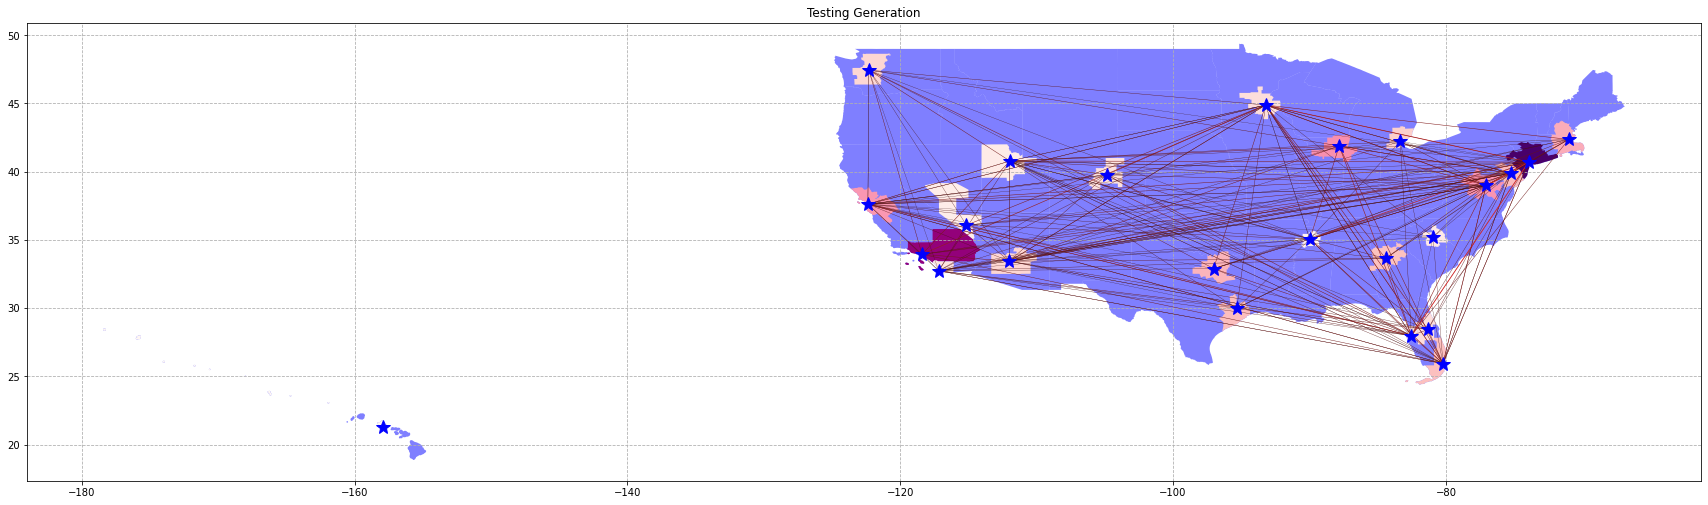

In [137]:
i=0.1
true_mean_test = torch.rand_like(data_X_val)*i
gen_test = model.decoder2(model.decoder1(true_mean_test))
fig = plot_OD2(gen_test, 'Testing Generation')
# fig.savefig('./imgs/clip/%i.png'%i, dpi=300)

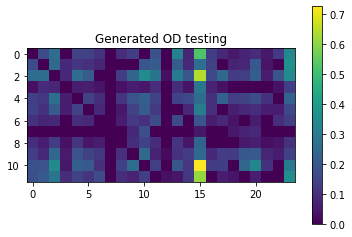

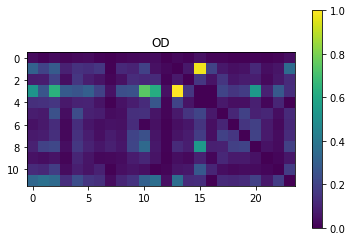

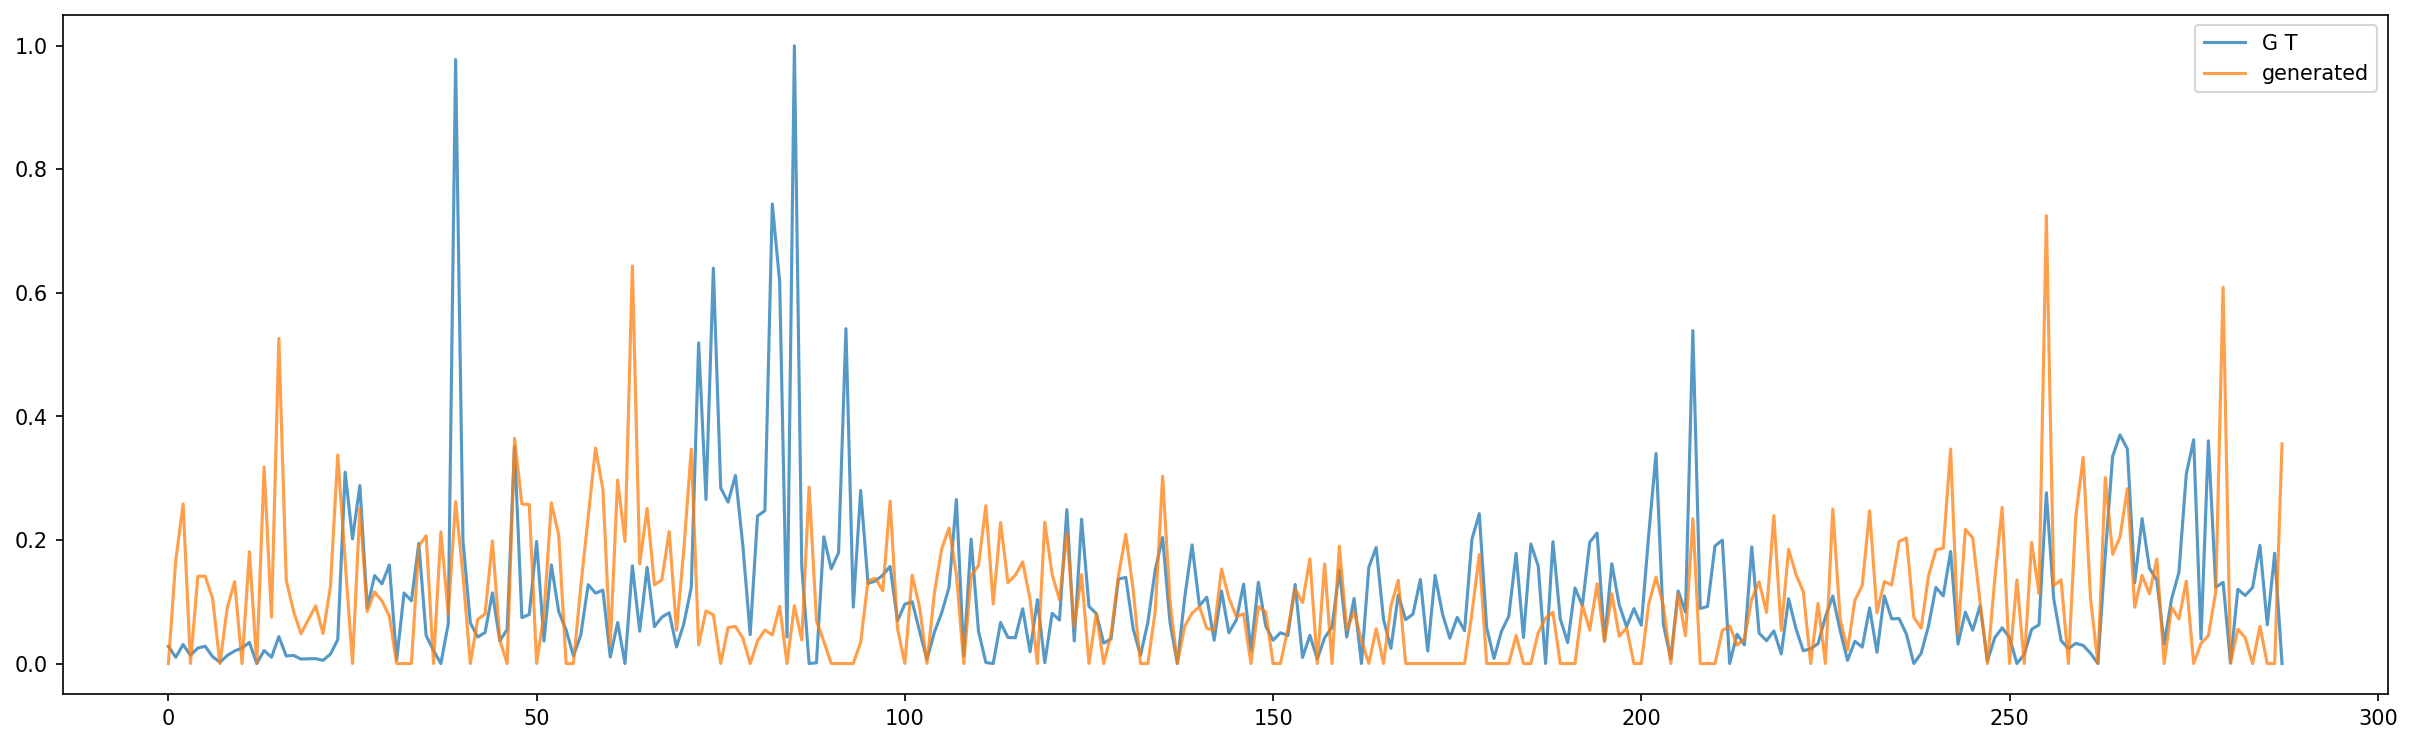

In [138]:
plt.figure()
plt.imshow(gen_test.detach().numpy().reshape(12,24))
plt.title('Generated OD testing')
plt.colorbar()
plt.figure()
plt.imshow(labels.reshape(12,24))
plt.title('OD')
plt.colorbar()
plt.figure(figsize=[20,6], dpi=150)
plt.plot(range(labels.shape[1]), labels.flatten(), label='G T', alpha=0.75)
plt.plot(range(gen_test.detach().numpy().shape[1]), gen_test.detach().numpy().flatten(), label='generated', alpha=0.75)
plt.legend()






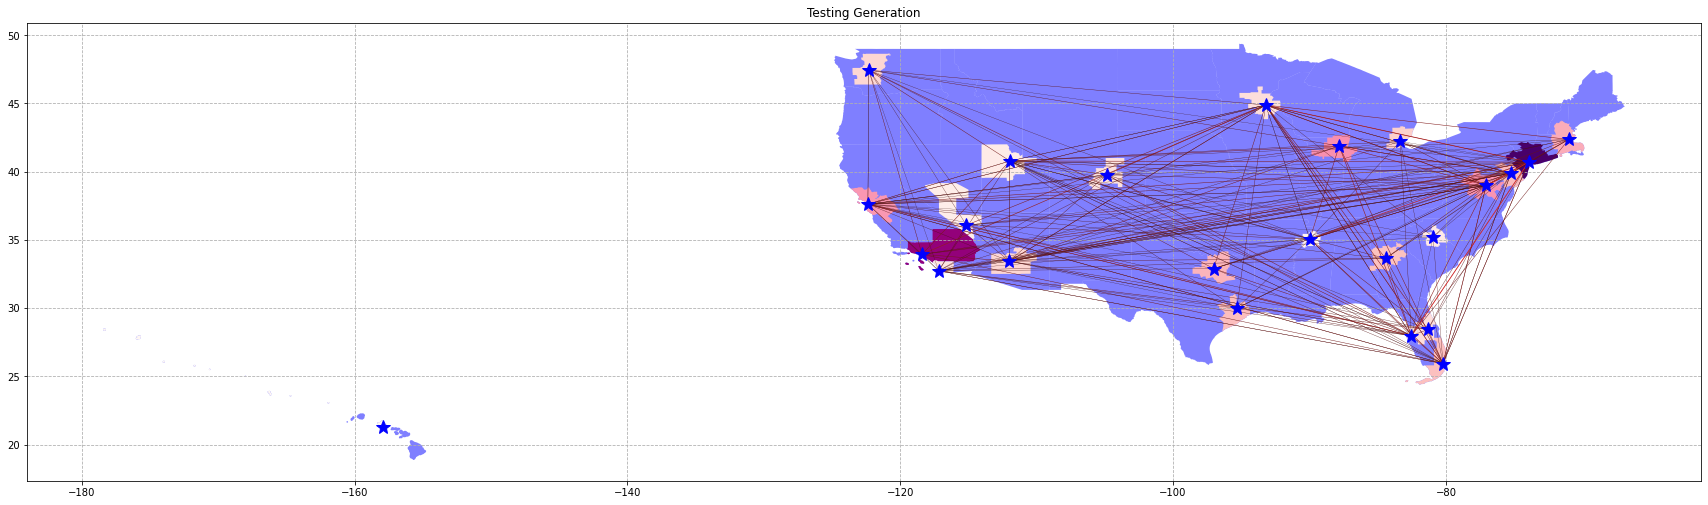

In [139]:
i=0.5
true_mean_test = torch.rand_like(data_X_val)*i
gen_test = model.decoder2(model.decoder1(true_mean_test))
fig = plot_OD2(gen_test, 'Testing Generation')
# fig.savefig('./imgs/clip/%i.png'%i, dpi=300)

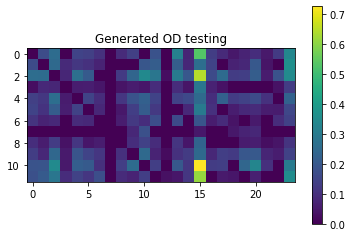

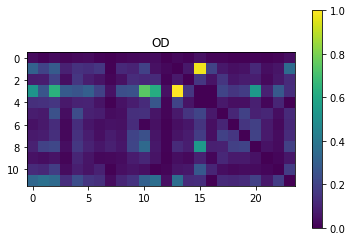

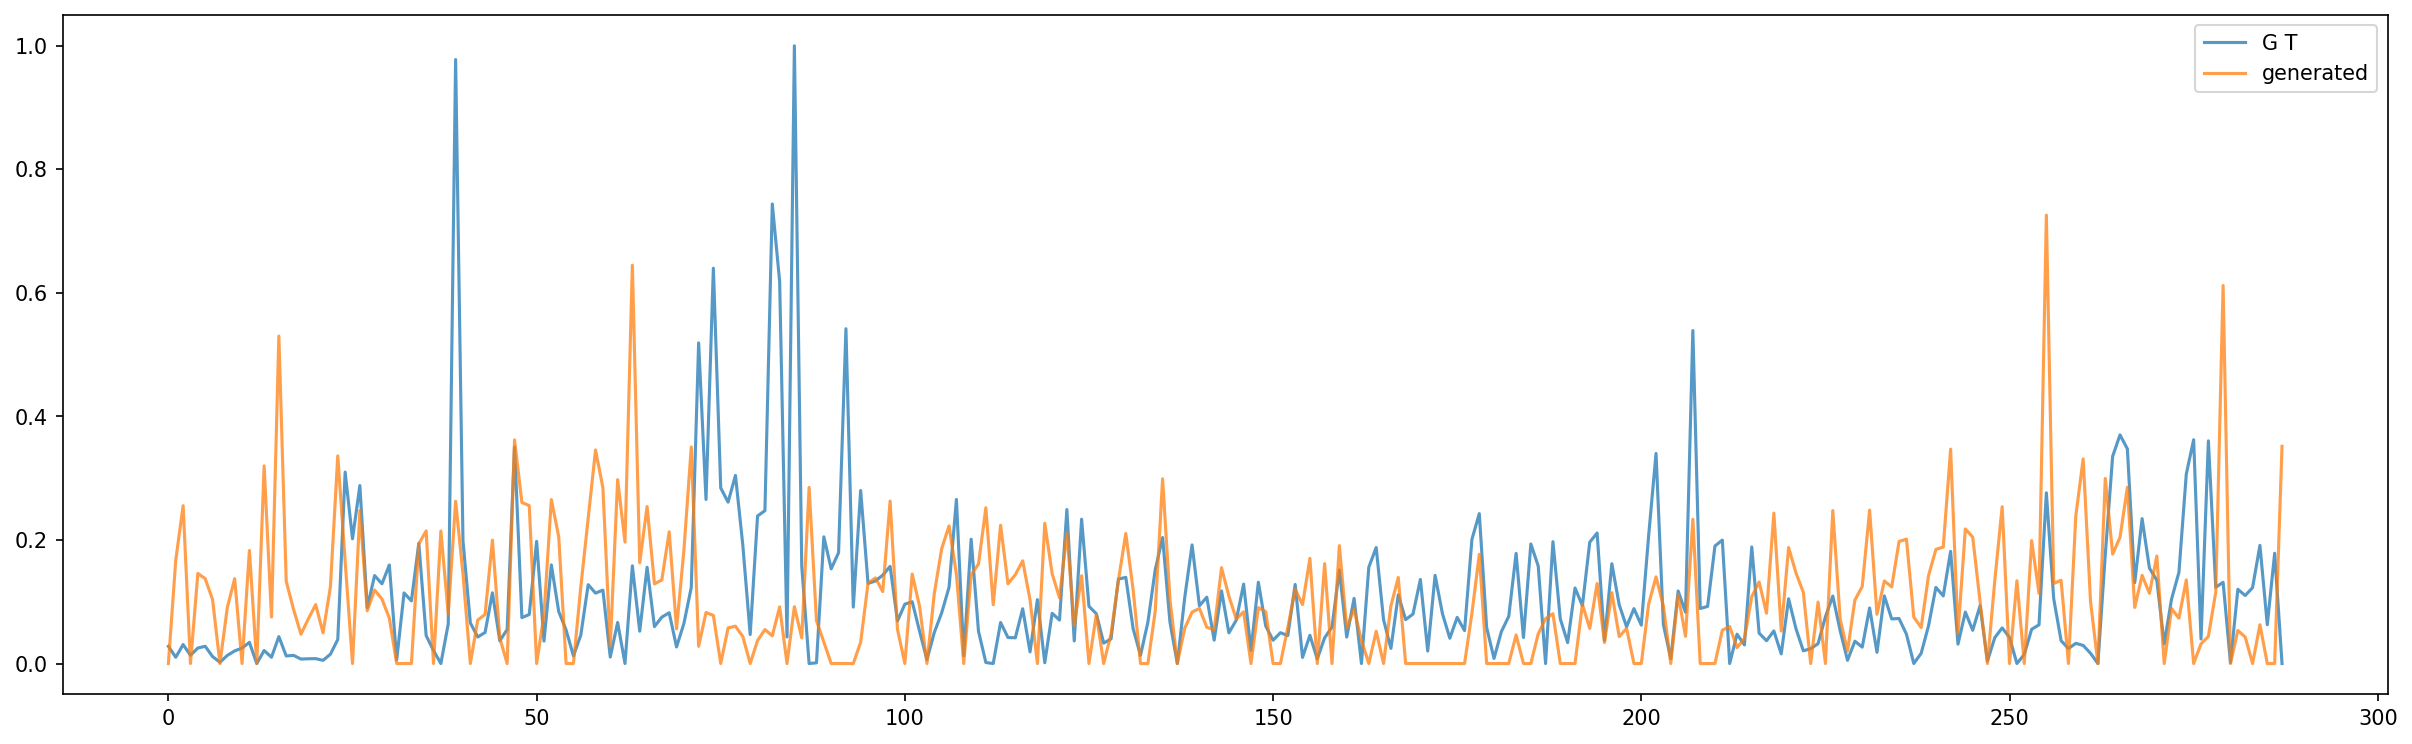

In [141]:
plt.figure()
plt.imshow(gen_test.detach().numpy().reshape(12,24))
plt.title('Generated OD testing')
plt.colorbar()
plt.figure()
plt.imshow(labels.reshape(12,24))
plt.title('OD')
plt.colorbar()
plt.figure(figsize=[20,6], dpi=150)
plt.plot(range(labels.shape[1]), labels.flatten(), label='G T', alpha=0.75)
plt.plot(range(gen_test.detach().numpy().shape[1]), gen_test.detach().numpy().flatten(), label='generated', alpha=0.75)
plt.legend()



